# Laboratorio 6
### Deep learning
- Daniel Gomez 21429
- Samuel Chamale 21881
- Adrian Rodriguez 21691

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import pickle

Datos de entrenamiento

1. `(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()`: Carga el conjunto de datos MNIST, dividiéndolo en imágenes y etiquetas de entrenamiento. El segundo conjunto (de prueba) no se utiliza, por eso se ignora con `_`.

2. `train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')`: Redimensiona las imágenes de entrenamiento para que tengan un formato de 28x28 píxeles con 1 canal (escala de grises) y convierte los valores a tipo `float32`.

3. `train_images = (train_images - 127.5) / 127.5`: Normaliza los valores de los píxeles, que originalmente están entre 0 y 255, para que queden en el rango [-1, 1]. Esto es importante para mejorar el rendimiento de las redes neuronales, especialmente cuando se usan activaciones como `tanh`, que esperan entradas en este rango.

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128

Este código crea un conjunto de datos (`train_dataset`) a partir de las imágenes de entrenamiento (`train_images`). Utiliza la función `from_tensor_slices` para convertir el array de imágenes en un formato compatible con TensorFlow, y luego aplica dos operaciones:

1. `shuffle(BUFFER_SIZE)`: Desordena aleatoriamente las imágenes utilizando un tamaño de buffer especificado por `BUFFER_SIZE`, lo que ayuda a mezclar los datos antes del entrenamiento.
2. `batch(BATCH_SIZE)`: Agrupa las imágenes en lotes del tamaño `BATCH_SIZE`, lo que permite que el modelo entrene en pequeños subconjuntos de datos en cada iteración.

Esto organiza las imágenes de entrenamiento para ser usadas de manera eficiente en el proceso de entrenamiento del modelo.

In [4]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

El generador toma un vector de 100 números aleatorios como entrada y lo transforma en una imagen de 28x28 píxeles. Usa capas densas, BatchNormalizatio), activación LeakyReLU, y varias capas Conv2DTranspose para aumentar el tamaño de la imagen gradualmente hasta obtener la salida final, que tiene una única capa de profundidad y usa la activación tanh para generar la imagen final.

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 64)))

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


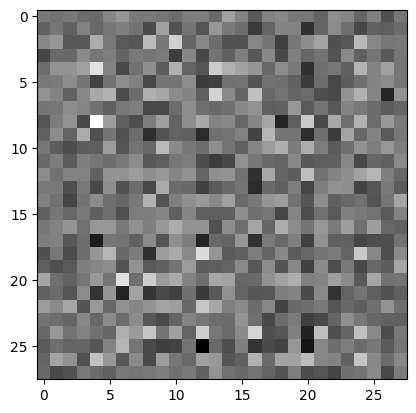

In [6]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

El discriminador toma una imagen de 28x28 píxeles como entrada y la procesa a través de capas convolucionales. Utiliza capas de `Dropout` para prevenir el sobreajuste y reduce la dimensionalidad de la imagen con una capa `Flatten`. Finalmente, una capa densa con una única salida determina si la imagen es real o generada por el modelo, proporcionando una probabilidad.

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00398176]], shape=(1, 1), dtype=float32)


In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

1. `real_loss`: Calcula la pérdida del discriminador al clasificar imágenes reales. Compara las salidas del discriminador (`real_output`) con un conjunto de etiquetas de unos (porque las imágenes reales deberían clasificarse como "reales"). Se utiliza la función de pérdida de entropía cruzada (`cross_entropy`) para esta comparación.

2. `fake_loss`: Calcula la pérdida del discriminador al clasificar imágenes generadas (falsas). Compara las salidas del discriminador (`fake_output`) con etiquetas de ceros (porque las imágenes generadas deberían clasificarse como "falsas").

3. `total_loss`: Suma las pérdidas de las imágenes reales y generadas para obtener la pérdida total del discriminador.

El objetivo es minimizar esta pérdida, de modo que el discriminador mejore en clasificar imágenes reales como reales y falsas como falsas.

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Esta función define la pérdida del generador. El objetivo del generador es crear imágenes falsas que engañen al discriminador haciéndole creer que son reales.

1. `fake_output`: Es la salida del discriminador al clasificar las imágenes generadas por el generador.

2. `cross_entropy(tf.ones_like(fake_output), fake_output)`: Calcula la pérdida del generador comparando las salidas del discriminador (`fake_output`) con un conjunto de etiquetas de unos (porque el generador quiere que el discriminador clasifique las imágenes falsas como "reales"). Se utiliza la función de entropía cruzada para medir qué tan bien está logrando esto.

El generador trata de minimizar esta pérdida, de modo que el discriminador no pueda diferenciar entre las imágenes reales y las generadas.

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

La anotación `@tf.function` optimiza la función compilándola para que sea más rápida.

1. **Generación de ruido**: Se crea un vector de ruido aleatorio con dimensiones `[BATCH_SIZE, noise_dim]` para alimentar al generador.

2. **GradientTape**: `
   - Se utilizan dos tf.GradientTape`, uno para el generador (`gen_tape`) y otro para el discriminador (`disc_tape`). Esto permite calcular los gradientes para ambos modelos.
   
3. **Generación de imágenes**: El generador usa el ruido para generar imágenes falsas (`generated_images`).

4. **Evaluación del discriminador**:
   - `real_output`: El discriminador procesa las imágenes reales y devuelve una clasificación.
   - `fake_output`: El discriminador evalúa las imágenes generadas y también devuelve una clasificación.

5. **Cálculo de pérdidas**:
   - `gen_loss`: Pérdida del generador, basada en qué tan bien las imágenes generadas engañan al discriminador.
   - `disc_loss`: Pérdida del discriminador, basada en su capacidad para diferenciar entre imágenes reales y generadas.

6. **Cálculo de gradientes**:
   - Se calculan los gradientes de la pérdida con respecto a los pesos entrenables del generador y el discriminador.

7. **Actualización de los modelos**:
   - `generator_optimizer.apply_gradients`: Aplica los gradientes calculados para actualizar los pesos del generador.
   - `discriminator_optimizer.apply_gradients`: Hace lo mismo para el discriminador.

En resumen, este bloque realiza un paso completo de entrenamiento, ajustando tanto el generador como el discriminador para que ambos mejoren en sus respectivos objetivos (engañar o no ser engañado).

In [13]:
g_losses = []
d_losses = []

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
    return gen_loss, disc_loss

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


1. **Inicio del bucle de épocas**:
   - El entrenamiento se repite por la cantidad de épocas definida en el argumento `epochs`.
   - Al inicio de cada época, se registra el tiempo con `start = time.time()` para medir cuánto tarda cada una.

2. **Entrenamiento por lotes**:
   - Dentro de cada época, se itera sobre cada lote de imágenes del conjunto de datos (`dataset`), llamando a la función `train_step(image_batch)` para entrenar el generador y discriminador en ese lote.

3. **Generación de imágenes**:
   - Se genera y guarda una imagen utilizando la función `generate_and_save_images(generator, epoch + 1, seed)`, donde el generador crea nuevas imágenes a partir de una semilla (`seed`), permitiendo un seguimiento visual del progreso de la GAN.

4. **Medición del tiempo**:
   - Se calcula y muestra el tiempo que tomó completar cada época con `print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))`.

5. **Generación final**:
   - Después de la última época, se genera una imagen final con el mismo método de visualización.

En resumen, esta función coordina el entrenamiento de la GAN durante múltiples épocas, mide el tiempo por cada una y genera imágenes en cada iteración para ver cómo mejora la calidad de las imágenes generadas.

Guardar modelo en pickle para evitar generarlo desde 0

In [16]:
# Function to save models
def save_models(generator, discriminator, filename='gan_models.pickle'):
    with open(filename, 'wb') as f:
        pickle.dump((generator.get_weights(), discriminator.get_weights()), f)

# Function to load models
def load_models(filename='gan_models.pickle'):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            gen_weights, disc_weights = pickle.load(f)
        
        generator = make_generator_model()
        discriminator = make_discriminator_model()
        
        generator.set_weights(gen_weights)
        discriminator.set_weights(disc_weights)
        
        return generator, discriminator
    return None, None

In [17]:
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss Over Time')
    plt.legend()
    plt.show()
    

def train(dataset, epochs):
    # Initialize lists to store loss values
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)  # Capture returned losses
            g_losses.append(gen_loss.numpy())  # Convert tensor to float and append
            d_losses.append(disc_loss.numpy())

        # Produce images for the GIF as you go
        # display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Print the time taken for the epoch
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    # Generate after the final epoch
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)
    

    # Plot the loss values after training
    plot_losses(g_losses, d_losses)


2024-10-04 16:05:55.296601: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


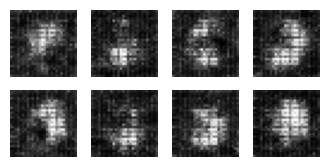

Time for epoch 1 is 14.162914276123047 sec


2024-10-04 16:06:08.655697: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


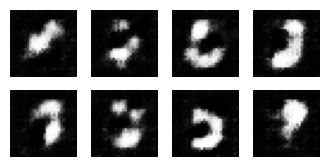

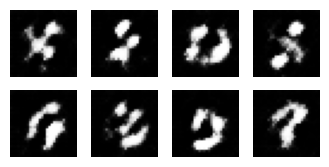

2024-10-04 16:06:35.828282: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


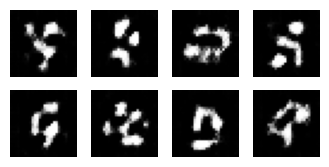

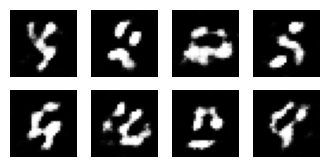

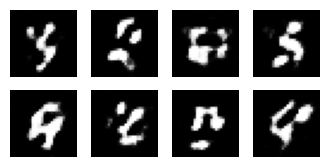

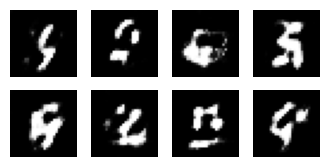

2024-10-04 16:07:27.664070: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


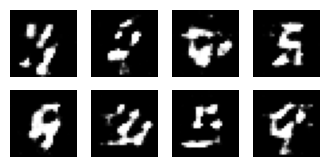

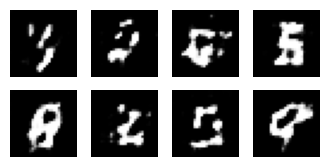

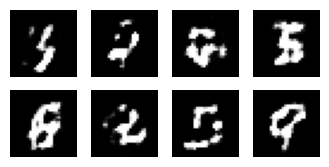

Time for epoch 10 is 12.453449010848999 sec


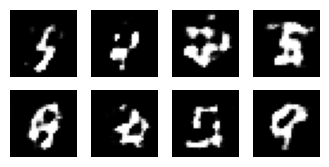

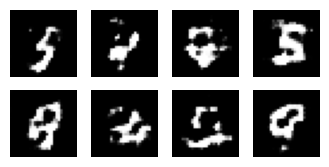

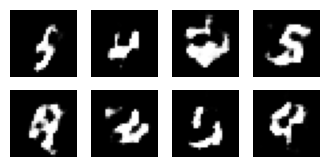

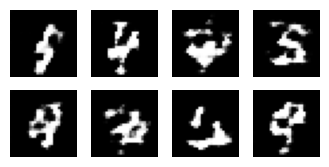

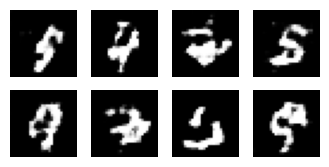

2024-10-04 16:09:10.264296: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


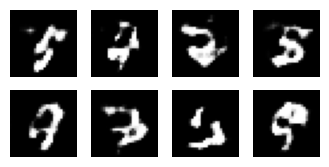

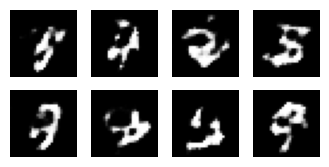

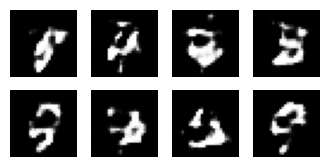

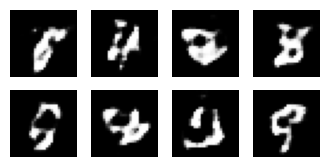

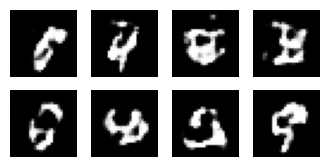

Time for epoch 20 is 13.115779161453247 sec


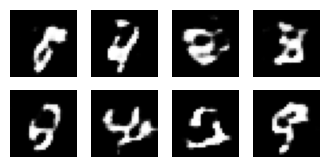

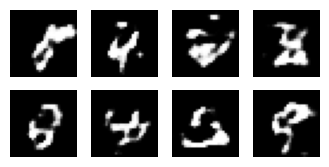

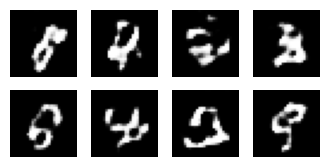

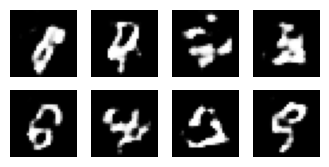

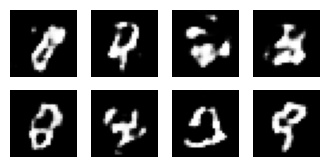

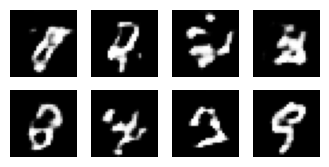

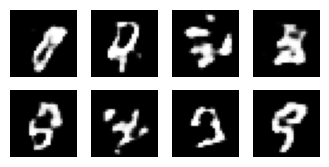

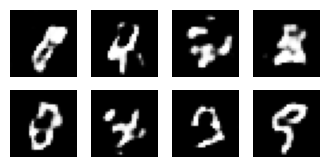

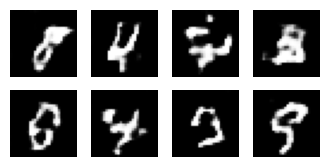

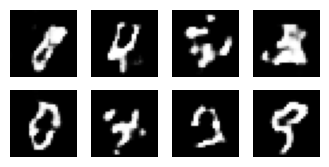

Time for epoch 30 is 12.554907083511353 sec


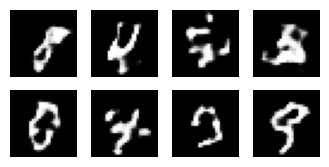

2024-10-04 16:12:36.585652: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


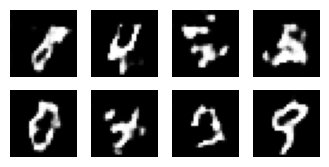

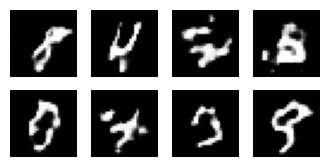

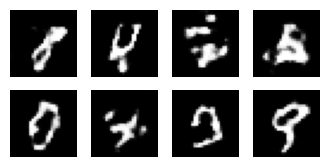

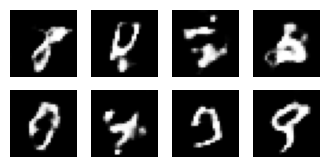

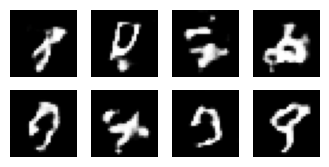

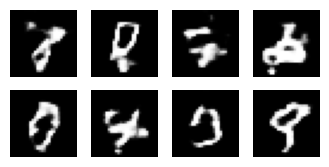

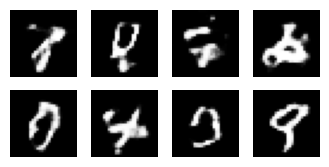

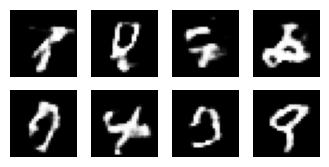

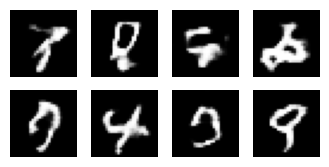

Time for epoch 40 is 13.641332149505615 sec


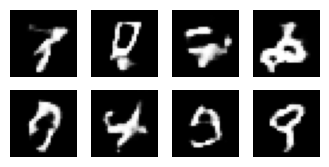

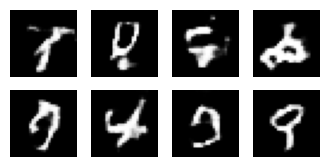

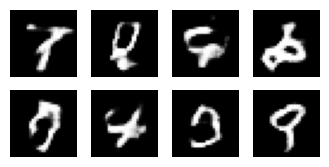

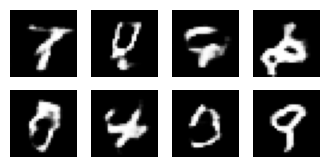

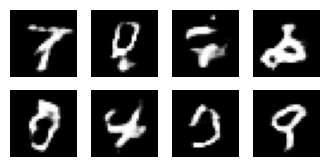

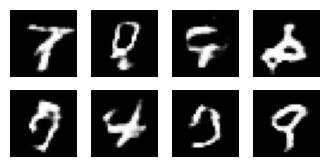

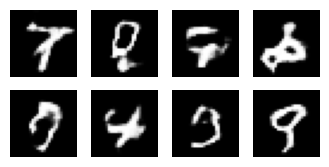

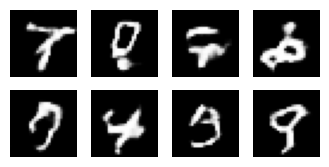

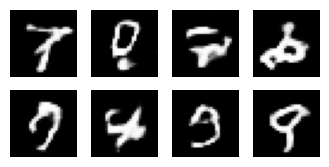

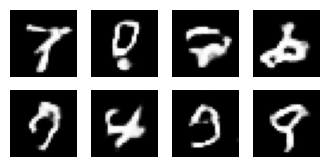

Time for epoch 50 is 13.456679105758667 sec


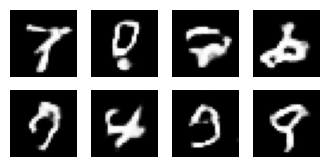

In [18]:
train(train_dataset, EPOCHS)

AttributeError: 'SymbolicTensor' object has no attribute 'numpy'

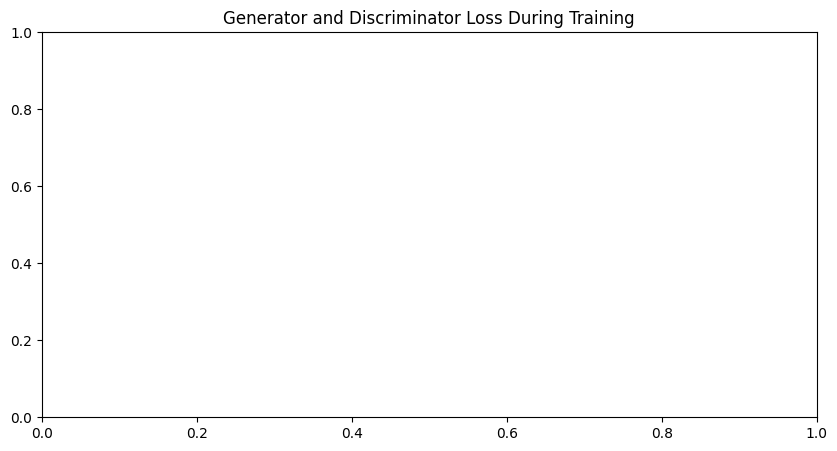

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot([tf.keras.backend.eval(loss) if isinstance(loss, tf.Tensor) else loss for loss in g_losses], label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()